7.7605583900858495
8.750301491390758
16.18048074081088
25.59884301904349
36.5498320586975
49.28435580429006


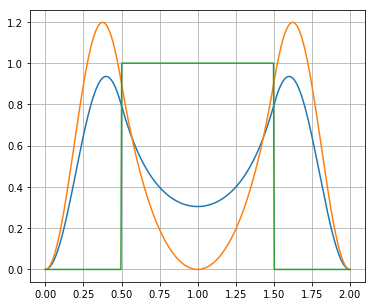

In [2]:
"""--------------------------------------------------------------*
Solution of Shrodinger Equation for the hard wall potential :

inside the potential well we have a step V = V0, i.e


-0.5*Psi'' = (E-V)*Psi (inside the potential well) -----(1)

where 

V = V0        for  x in [L/4,3L/4]
V = 0         for  x in [0,L/4[ U ]3L/4,L]
V = Infinity   ortherwise

Below are the the  solutions without the step, i.e. hard wall potential :

Psi_n(x) = sqrt(2/L)*sin(n*w*x) see below ...

E_n = (n**2)*E0  

-----------------------------------------------------------------*
"""
import  numpy as np
import  matplotlib.pyplot  as plt        
from    scipy.integrate import odeint
from    scipy.integrate import simps
from    scipy.optimize  import brentq

"""
Using the scipy ODE solver odeint

The problem 

-0.5*Psi''  = (E-V)*Psi

should be formulates as 

Psi' = z
                     ------- (2)
z'   = -2*(E-V)*psi
"""

V0  = 10.0
L   = 2.0
a   = 0.5
b   = 1.5

def V(x):
    if (x>=a and x<=b):
        return (V0)
    else:
        return (0.0)

N = 400
x = np.linspace(0,L,N)
h = x[1]-x[0]

"""
This  function provides the derivatives of the tuple(Psi,z)
(Psi, z) ----> func ---->(Psi',z')
""" 
def func(initVal,x,E):
    psi, z = initVal
    return [z, -2*(E-V(x))*psi]

# psi' = (1E-3 - 0)/h this method is sensitive to this value
# psi_0= 0, I chose psi_1=1E-3, hence the initial condition below
initVal = [0 , 1.0E-3/h] # Psi(0) =0, momentum 1E-4 very small

"""
Usint the shooting method, E is tuned as to make psi(L)=0
"""

def shoot(E):
    sol = odeint(func, initVal, x, args=(E,))  
    psi = sol[:,0]
    return psi[-1]/max(np.abs(psi))
    
Erange = [np.float64(r) for r in range(60)] # engergies from 1.0...60.0
dE = 1.0
Psi = []
for E0 in Erange:
    if (shoot(E0)*shoot(E0+dE)<0): # if solution exists in the interval
        En = brentq(shoot, E0, E0+dE, args=())
        # finding the wave function
        y = odeint(func, initVal, x, args=(En,))
        psi = y[:,0]
        norm = simps(psi**2, dx = h)
        psi = psi/np.sqrt(norm)
        Psi.append(psi)
        print(En)
        
Vp = [V(t)/10 for t in x]        
plt.figure(figsize=[6,5])
plt.grid()
plt.plot(x,Psi[0]**2)
plt.plot(x,Psi[1]**2)
#plt.plot(x,Psi[2]**2)
plt.plot(x,Vp)
plt.show()

In [2]:
"""--------------------------------------------------------------*
Solution of Shrodinger Equation for the hard wall potential 

inside the potential well we have a step V = V0, i.e

This time a basis functions will be used for a variationel calculation


-0.5*Psi'' = (E-V)*Psi (inside the potential well) -----(1)

where 

V = V0        for  x in [L/4,3L/4]
V = 0         for  x in [0,L/4[ U ]3L/4,L]
V = Infinity   ortherwise

Below are the the  solutions without the step, i.e. hard wall potential :

Psi_n(x) = sqrt(2/L)*sin(n*w*x) see below ...

E_n = (n**2)*E0  

They will serve as a basis function

-----------------------------------------------------------------*
"""
import  numpy as np
import  matplotlib.pyplot  as plt        
from    scipy.integrate import odeint
from    scipy.integrate import simps
from    scipy.optimize  import brentq
import  scipy.integrate as integrate

#--------------------------------------------------------------------------------------#
#         Basis function :  plane waves solutions of the hard wall potential
#--------------------------------------------------------------------------------------#
L  = 2.0
w  = np.pi/L
A  = np.sqrt(2/L)
E0 = 0.5*w**2

def psi(n):
    def tmpFunc(x):       
        return (A*np.sin(n*w*x))
    return(tmpFunc)

def E(n):
    return ((n**2)*E0)
#--------------------------------------------------------------------------------------#
# Check for ortogonality
print(" <4|3> :", integrate.quad(lambda x:psi(4)(x)*psi(3)(x), 0.0, L))
print(" <4|4> :", integrate.quad(lambda x:psi(4)(x)**2, 0.0, L))
V0  = 10.0
a   = 0.5
b   = 1.5

def V(x):
    if (x>=a and x<=b):
        return (V0)
    else:
        return (0.0)
n = 50;    
    
H = np.zeros([n,n])# Hamiltonian matrix

for i in range(n):
    for j in range(i,n):
        tmp =integrate.quad(lambda x:psi(i+1)(x)*psi(j+1)(x), a, b) 
        H[j,i]=H[i,j] = V0*tmp[0]
        if (i==j): 
            H[i,j]+=E(i+1)

eigenValues, eigenVectors = np.linalg.eig(H)

idx = eigenValues.argsort()

En           = eigenValues[idx]
Coef         = eigenVectors[:,idx]

print("Eigen energies:")
for i in range(6):
    print(En[i])

 <4|3> : (6.182239490983957e-17, 8.91075920364709e-15)
 <4|4> : (1.0000000000000002, 7.339841178823791e-10)
Eigen energies:
7.76062796483
8.75038139897
16.1804854957
25.5988555262
36.5499062813
49.2844440532


7.76062796483
8.75038139897
16.1804854957
25.5988555262
36.5499062813
49.2844440532
65.1450523544
84.1896504422
105.323212351
128.321129421


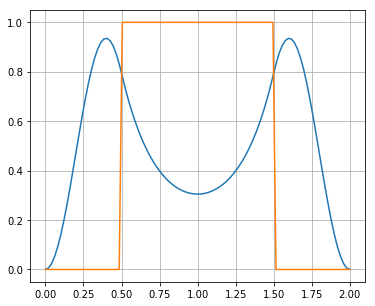

In [6]:
"""
Variational method as above with better coding ....

"""
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import brentq
from scipy.integrate import quad
import math

class infiniteWellWaveFunctions:
    " V = infinity at 0 and L "
    def __init__(self,L):
        self.L          = L
        self.NormFactor = math.sqrt(2.0/L)
        self.k0         = math.pi/L
        self.E0         = self.k0**2/2.0       

    def E(self,n):
        return n**2*self.E0
     
    def psi(self,n):
        def tmp(x):
            return self.NormFactor*math.sin(n*self.k0*x)
        return tmp

    def dotProduct(self,n,m):
        def n_dot_m(x):
            return self.psi(n)(x)*self.psi(m)(x)
        return quad(n_dot_m,0,self.L)              

    def OperatorExpectedValue(self, n,O, m) :  
        """ O should be a function of x """
        def n_dot_O_dot_m(x):
            return self.psi(n)(x)*O(x)*self.psi(m)(x)
        return quad(n_dot_O_dot_m,0,self.L)
  

V0 = 10.0

def V(x):
    if (x<0.5 or x>1.5): return 0.0
    else: return V0

s = infiniteWellWaveFunctions(L = 2)

N = 50
H = np.zeros([N,N])  

for i in range(N):
    for j in range(i,N):
        # i,j start from 0, but n.m starts from 1
        H[j,i]=H[i,j]= s.OperatorExpectedValue( i+1,V,j+1)[0]
    H[i,i]+=s.E(i+1)
      
[Eval, Evect]= np.linalg.eig(H)

# Evect contains the coefecient in the bases {psi(i)}, i=1 to N

idx = np.argsort(Eval)                                            

sortedEnergies = Eval[idx]
sortedEvects   = Evect[:,idx]

for t in range(10): print(sortedEnergies[t])

def generateWaveFunction(n,x): 
    cn = sortedEvects[:,n]
    d = 0.0
    for i in range(len(sortedEvects)) :
        d+=cn[i]*s.psi(i+1)(x)
    return d
    
x = np.linspace(0,s.L,100)
y = [generateWaveFunction(0,t)**2 for t in x] 
Vp = [V(t)/10 for t in x]        
plt.figure(figsize=[6,5])
plt.grid()
plt.plot(x,y)
plt.plot(x,Vp)
plt.show()